# mnist with mlp : practice baseline for pytorch

## 1. model import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import dataloader, dataset

## 2. 딥러닝 모델을 설계할 떄 활용하는 장비 확인

In [3]:
device = torch.devcie('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using Pytorch version :", torch.__version__, ' Device :', device)

Using Pytorch version : 1.7.1  Device : cpu


In [4]:
batch_size = 8
epochs = 1

## 3. MNIST 데이터 다운로드, train set, test set 분리하기

In [5]:
train_dataset = datasets.MNIST(root = 'python/pytorch_tutorial/pytorch_book/mnist',
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = 'python/pytorch_tutorial/pytorch_book/mnist',
                               train = False,
                               transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to python/pytorch_tutorial/pytorch_book/mnist/MNIST/raw/train-images-idx3-ubyte.gz
 97%|█████████▋| 9584640/9912422 [00:03<00:00, 4324192.85it/s]Extracting python/pytorch_tutorial/pytorch_book/mnist/MNIST/raw/train-images-idx3-ubyte.gz to python/pytorch_tutorial/pytorch_book/mnist/MNIST/raw

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to python/pytorch_tutorial/pytorch_book/mnist/MNIST/raw/train-labels-idx1-ubyte.gz

 57%|█████▋    | 16384/28881 [00:00<00:00, 76133.17it/s]

0it [00:00, ?it/s]Extracting python/pytorch_tutorial/pytorch_book/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to python/pytorch_tutorial/pytorch_book/mnist/MNIST/raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

  1%|          | 16384/1648877 [00:00<00:23, 70210.32it/s]

  3%|▎         | 49152/1648877 [00:00<00:18, 84801.02it/s]

  6%|▌         | 98304/1648877 [00:01<00:14, 105616.3

## 4. 데이터 확인하기 (1)

In [6]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([8, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([8]) type: torch.LongTensor


## 5. 데이터 확인하기 (2)

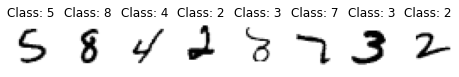

In [8]:
plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap = 'gray_r')
    plt.title('Class: ' + str(y_train[i].item()))

## 6. MLP(Multi Layer Perceptron) 모델 설계하기

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

## 7. optimizer, Objective Function 설정하기

In [12]:
model = Net()
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum= 0.9)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


## 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의

In [13]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                Epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()
            ))

## 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

In [14]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 10. mlp 학습을 실행하며 Train, Test set 의 loss 및 Test set accuracy 확인하기

In [15]:
for Epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} \n".format(
        Epoch, test_loss, test_accuracy
    ))

Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.310533
Train Epoch: 1 [1600/60000(3%)]	Train Loss: 2.441566
Train Epoch: 1 [3200/60000(5%)]	Train Loss: 2.243018
Train Epoch: 1 [4800/60000(8%)]	Train Loss: 2.315877
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 2.124791
Train Epoch: 1 [8000/60000(13%)]	Train Loss: 1.955962
Train Epoch: 1 [9600/60000(16%)]	Train Loss: 1.127036
Train Epoch: 1 [11200/60000(19%)]	Train Loss: 1.310496
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.702869
Train Epoch: 1 [14400/60000(24%)]	Train Loss: 0.426129
Train Epoch: 1 [16000/60000(27%)]	Train Loss: 0.367509
Train Epoch: 1 [17600/60000(29%)]	Train Loss: 0.738664
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.293368
Train Epoch: 1 [20800/60000(35%)]	Train Loss: 0.428390
Train Epoch: 1 [22400/60000(37%)]	Train Loss: 0.214408
Train Epoch: 1 [24000/60000(40%)]	Train Loss: 0.328750
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.859001
Train Epoch: 1 [27200/60000(45%)]	Train Loss: 0.716806
Train Epoch: 1 [28800/60